In [28]:
%matplotlib inline
import os
import json
from shutil import copy
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from PIL import Image

from pycocotools.coco import COCO
from pycocotools.cbas import CBAS
import cbas_construction_utils as ccu

pylab.rcParams['figure.figsize'] = (8.0, 6.0)

# Creating the CBAS-80 and CBAS-36 datasets
* CBAS = COCO Big And Small
* Inspired by the CIFAR-100 and CIFAR-10 datasets
    * CIFAR = Canadian Institute For Advanced Research
    * CIFAR-10 and CIFAR-100 the two of the most utilized datasets in computer vision research
    * Their small image sizes (36 pixels by 36 pixels) make them managable for rapid prototyping yet more challenging than MNIST.

### Load COCO API

In [38]:
# We'll create CBAS-80 out of the COCO "train2017" image set
originSet = 'train2017'

# initialize COCO api for instance annotations and category info
coco=COCO('../annotations/instances_{}.json'.format(originSet))

loading annotations into memory...
Done (t=13.93s)
creating index...
index created!


### Display COCO categories and supercategories

In [9]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic indoor outdoor sports kitchen furniture food person appliance vehicle animal accessory


# Create CBAS-80
### Use COCO API to crop multiple instances out of each COCO image

CBAS-80 consists of small (3x32x32) images cropped from COCO images across all 80 categories

In [41]:
newSet = 'cbas80' # we won't split into train/val, yet

In [49]:
# ensure directory exists
set_directory = '../images/{}'.format(newSet)
if not os.path.exists(set_directory): 
    print('Creating new directory: ' + set_directory)
    os.makedirs(set_directory)

In [55]:
imgIds = coco.getImgIds() # get all img ids
annIds = coco.getAnnIds() # get all ann ids

num_imgs = len(imgIds)
num_anns = len(annIds)

print("There are " + str(num_imgs) + ' images and ' + 
      str(num_anns) + ' object instances in the COCO dataset')

There are 118287 images and 860001 object instances in the COCO dataset


In [4]:
annotations = {'images':[]}

thumbnail_sz=(32,32) # the size we're cropping to

# for each image...
for j,i in enumerate(imgIds):
    coco_img = coco.loadImgs(i)[0] # load image
    img = Image.open('../images/{}/{}'.format(originSet,coco_img['file_name']))

    # load instance annotations for 'this' image
    annIds = coco.getAnnIds(imgIds=coco_img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)

    # Crop each instance out of 'this' image
    #  - compute size ratio 
    #  - save image and annotation
    for a in anns:
        
        # Try to crop the object instance out of the larger image
        # - also return the box used to crop the image (this will be used to calculate the correct size ratio)
        crop, cropbox = ccu.maxsquarecrop(img,a['bbox'],thumbnail_sz[0])
        
        if crop: # ensure cropped image was successfully returned, if not just skip
            
            # Compute the ratio of object area to image area
            #  - to get object area: intersect the object (instance) segmentation with the box used for cropping
            #  - the reason we need to do this intersect is that the annotation may have gotten cropped as well ...
            #  - ... in which case using the original instance segmentation area would lead to small errors
            size_ratio = ccu.segbox_intersect_area(a, cropbox, coco)/(cropbox[2]*cropbox[3])
            
            # Set a minimum size ratio
            if size_ratio > 0.1:
                
                # Shrink the cropped image
                if thumbnail_sz:
                    crop = crop.resize(thumbnail_sz, Image.ANTIALIAS)
                    
                # Create a directory string that uses the category name 
                #  - (for compatibility with pytorch's torchvision.datasets.ImageFolder data loader)
                class_directory = '../images/{}/{}'.format(newSet,str(coco.cats[a['category_id']]['name'].replace(" ", "")))

                # ensure directory exists
                if not os.path.exists(class_directory): 
                    os.makedirs(class_directory)
                    
                # Save                                 
                crop.save('{}/{}'.format(class_directory,str(a['id'])+'.jpg'))
                
                # Record annotation
                annotations['images'].append({'id':a['id'], 'category_id':a['category_id'], 'size_ratio':size_ratio})
         
    # Display progress
    if (j % 5000) == 0: print(str(j) + ' images complete')
        
# Report image numbers         
print(str(len(annotations['images'])) + ' images saved to ' + '../images/{}'.format(newSet))

0 images complete
14071 images saved to ../images/cbas80test_val


TypeError: not all arguments converted during string formatting

### Create CBAS-80 annotation file
I separated this into its own cell in case something goes wrong (i.e. file path error) - you would not have to re-run the image cropping which can take a while if your doing train2017

In [6]:
# add COCO category info to CBAS annotations dictionary
annotations['categories'] = coco.dataset['categories']
# write to file
with open('../annotations/{}.json'.format(newSet), 'w') as outfile:
    json.dump(annotations, outfile)

# Explore CBAS-80
* use statistical analysis of CBAS-80 to define the parameters of CBAS-36

In [42]:
# first load CBAS-80 annotation file
cbas80=CBAS('../annotations/{}.json'.format(newSet))

# Get category index so we can go from image ids to category names
idToName={}
for c in cbas80.dataset['categories']:
    idToName[str(c['id'])]=c['name']

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [58]:
cImgIds = cbas80.getImgIds() # get all img ids

num_imgs = len(cImgIds)

print("There are " + str(num_imgs) + ' images in the CBAS-80 dataset')

There are 325665 images in the CBAS-80 dataset


### Display rows of images of a given categories where size ratio progressively increases

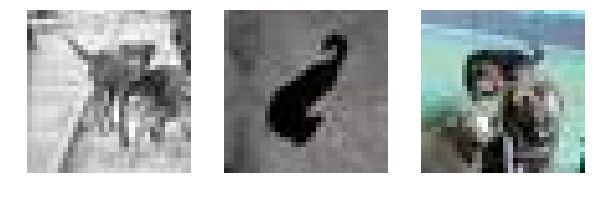

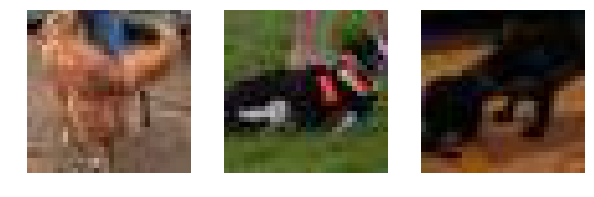

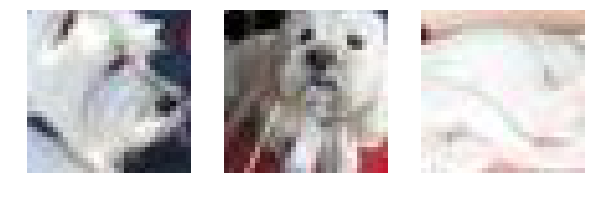

In [44]:
# get all images containing a chosen category
catIds = cbas80.getCatIds(catNms=['dog']);

# define size bins
szBins = [[0.1,0.15], [0.3,0.5], [0.8,0.9]]

# plotting loop
for b in szBins:
    fig = plt.figure(figsize=(10,3))
    imgs = []
    
    # for each size bin, display a row of 3 random images
    imgIds = cbas80.getImgIds(catIds=catIds,szBounds=b);
    for i in range(0,3):
        cimg = cbas80.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
        imgid = str(cbas80.imgToAnns[cimg['id']][0]['category_id'])
        catstr = str(idToName[imgid].replace(" ", ""))
        class_directory = '../images/{}/{}'.format(newSet,catstr)
        
        imgs.append(io.imread('{}/{}.jpg'.format(class_directory,cimg['id'])))
        
    sub1 = fig.add_subplot(131)
    sub1.axis('off')
    sub1.imshow(imgs[0])
    sub2 = fig.add_subplot(132)
    sub2.axis('off')
    sub2.imshow(imgs[1])
    sub3 = fig.add_subplot(133)
    sub3.axis('off')
    sub3.imshow(imgs[2])
    plt.show()

NOTES:
* I see duplicate images here and there - need to 'de-dupe' somehow
* In the smallest bin, the objects are not THAT small.  To make a more difficult task, we should lower the size ratio of the smallest bin

### Look at the distribution of image counts across size-ratio bins
* This is important because we ultimately want an even distribution across the size bins that we choose
    * the reason being, we want to be able to say that one size bin is easier/harder than another because of the object appearance (not because one size has more training examples)

The distribution for "person" dwarfs the other categories:


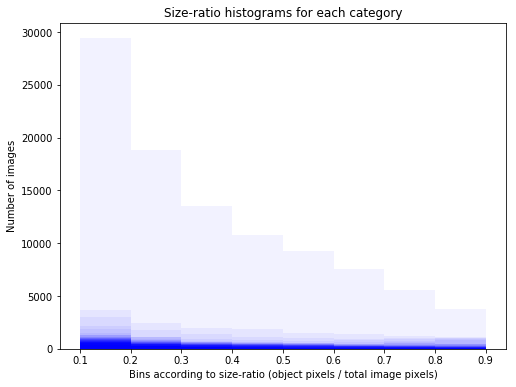

In [45]:
print('The distribution for "person" dwarfs the other categories:' )
fig = plt.figure()
ax = fig.add_subplot(111)
for t in cbas80.cats:
    sizes = []
    imgIds = cbas80.getImgIds(catIds=[t]);
    for i in imgIds:
        sizes.append(cbas80.imgToAnns[i][0]['size_ratio'])
    ax.hist(np.array(sizes), bins=np.arange(0.1, 1.0, 0.1), alpha = 0.05, color='blue')

ax.set_title("Size-ratio histograms for each category");
ax.set_xlabel('Bins according to size-ratio (object pixels / total image pixels)');
ax.set_ylabel('Number of images');

Se we zoom in:


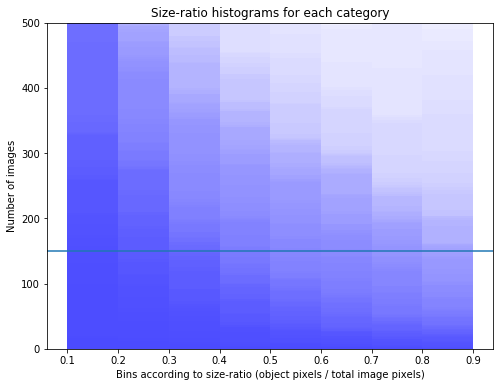

In [47]:
print('Se we zoom in:' )
fig = plt.figure()
ax = fig.add_subplot(111)
for t in cbas80.cats:
    sizes = []
    imgIds = cbas80.getImgIds(catIds=[t]);
    for i in imgIds:
        sizes.append(cbas80.imgToAnns[i][0]['size_ratio'])
    ax.hist(np.array(sizes), bins=np.arange(0.1, 1.0, 0.1), alpha = 0.01, color='blue')

ax.set_title("Size-ratio histograms for each category");
ax.set_xlabel('Bins according to size-ratio (object pixels / total image pixels)');
ax.set_ylabel('Number of images');
ax.set_ylim(0, 500); # can try some different values here
ax.axhline(y=150) # draw a line

* The trade-off we're making is:
    * The higher the bar:
        * The more images per size-bin
        * The less categories we can use (because less categories will meet the minimum images-per-bin to make an even distribution)
        
        
* To make this choice easier, we can search for a minimum images-per-bin so that it maximizes the total images in our dataset with the following constraints:
    * We need at least 10 categories
    * We need at least 100 images per bin

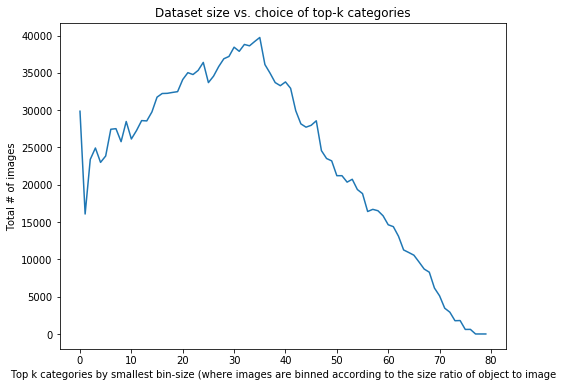

In [48]:
# Look at the minimum bin size for each category
id_counts=[]
bins=[[0.1,0.2],[0.2,0.3],[0.3,0.4],[0.4,0.5],[0.5,0.6],[0.6,0.7],[0.7,0.8],[0.8,0.9]]
for cat in cbas80.cats:
    bin_counts=[]
    for b in bins:
        bin_counts.append(len(cbas80.getImgIds(catIds=[cat], szBounds=b)))
    id_counts.append([cat,min(bin_counts)])
    
binmins = sorted(id_counts,key=lambda l:l[1], reverse=True)#[0:36]

total_imgs=[]
for i,b in enumerate(binmins):
    #total_imgs.appen(idToName[str(b[0])] + ': min:' + str(b[1]) + ' total images:' + str(b[1]*8*(i+1)))
    total_imgs.append(b[1]*8*(i+1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_imgs)
ax.set_title("Dataset size vs. choice of top-k categories");
ax.set_xlabel('Top k categories by smallest bin-size (where images are binned according to the size ratio of object to image' );
ax.set_ylabel('Total # of images');

Using this criteria, the top 36 categories will yield that largest dataset overall (39,744 images) given our constraints:
* 36 categories
* 8 bins per category
* 138 images per size bin

* 138x8x36 = 39,744 images

### Train/val splits

Split the 39,744 images into:
* 36,000 training images 
    * 1k images per category
    * 125 images per size bin per category)
* 3,744 validation images 
    * 104 images per category
    * 13 images per size bin per catgory)

# Create CBAS-36
* randomly select a subset of images from CBAS-80 and copy them into a new (CBAS-36) directory

In [ ]:
newSet2 = 'cbas36'

In [39]:
if not cbas80: # prob already loaded this
    cbas80=CBAS('../annotations/{}.json'.format(newSet))

# Get category index so we can go from image ids to category names
if not idToName:
    idToName={}
    for c in cbas80.dataset['categories']:
        idToName[str(c['id'])]=c['name']

In [35]:
# Get top 36 categories according to min(image counts across size bins)
#  - i.e. we want the categories that have the largest min counts because that means ...
#  - we can have an even distribution of examples across size bins
id_counts=[]
sizebins=[[0.1,0.2],[0.2,0.3],[0.3,0.4],[0.4,0.5],[0.5,0.6],[0.6,0.7],[0.7,0.8],[0.8,0.9]]
for cat in cbas80.cats:
    bin_counts=[]
    for b in sizebins:
        bin_counts.append(len(cbas80.getImgIds(catIds=[cat], szBounds=b)))
    id_counts.append([cat,min(bin_counts)])
    
top36 = sorted(id_counts,key=lambda l:l[1], reverse=True)[0:36]

#for t in top36: print(t)

In [36]:
for t in top36:
    # randomly select 138 images from each size bin
    imgIds={}
    imgIds['train'] = []
    imgIds['val'] = []
    for szbin in sizebins:
        theseImgIds = cbas80.getImgIds(catIds=t[0],szBounds=szbin)
        rand_selection = np.random.choice(theseImgIds, size=138, replace=False)
        imgIds['train'] += rand_selection.tolist()[:125]
        imgIds['val'] += rand_selection.tolist()[125:]
        
    for dType in ['train', 'val']:
        # copy over each image to new folder
        for i in imgIds[dType]:
            # Get category string with no spaces for folder paths
            catstr = str(idToName[str(t[0])].replace(" ", ""))

            src = '../images/{}/{}/{}.jpg'.format(newSet,catstr,i)

            class_directory = '../images/{}_{}/{}'.format(newSet2,dType,catstr)

            # Ensure destination directory exists
            if not os.path.exists(class_directory):
                            os.makedirs(class_directory)

            dst = '{}/{}.jpg'.format(class_directory,i)
            
            copy(src,dst)
            
print('Finished copying images into {}'.format('../images/{}'.format(newSet2)))

If that worked, you can try running the training demo notebook